In [1]:
# this is just to know how much time will it take to run this entire ipython notebook 
from datetime import datetime

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')

In [4]:
import os

## reading data from the csv file

In [ ]:
df = pd.read_csv('data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)

# we are arranging the ratings according to time.
df.sort_values(by='date', inplace=True)
df.head()

In [5]:
df = pd.read_csv('data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)

# we are arranging the ratings according to time.
df.sort_values(by='date', inplace=True)
df.head()

,movie,user,rating,date
58698779,10774,510180,3.0,1999-11-11
96212476,17064,510180,2.0,1999-11-11
6901473,1367,510180,5.0,1999-11-11
49973109,9003,510180,3.0,1999-11-11
20393918,3870,510180,2.0,1999-11-11


### Is there any entry that has Nan values...??

In [6]:
# it returns True for a row that has atleast one Nan value.
null_bool = df.isnull().any(axis = 1)
df[null_bool]

,movie,user,rating,date
95880696,16992,962,NaN,NaT
95963294,17002,51082,NaN,NaT


In [7]:
df.drop(df[null_bool].index, inplace=True)

In [8]:
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


### Let's try to find the duplicates if any...

In [9]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp )
print("There are {} duplicate rating entries in the data..".format(dups))

There are 1211 duplicate rating entries in the data..


In [10]:
# let's find what are the movies that has duplicate entries of user ratings....
df[dup_bool].movie.value_counts()

16969    762
16968    449
Name: movie, dtype: int64

__Removing those duplicate entries__  (inplace)

In [11]:
df.drop(df[dup_bool].index, inplace=True)

In [12]:
print("No of duplicate rows (movie, user, rating) entries :", sum(df.duplicated()))

No of duplicate rows (movie, user, rating) entries : 0


In [13]:
print("\nNo of ratings that we have, after removing nan rows and duplicates are :", df.shape[0])


No of ratings that we have, after removing nan rows and duplicates are : 100479045


## No. of Ratings, Users and Movies  

In [14]:
movies = df.movie.value_counts()
users = df.user.value_counts()
ratings = df.rating
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(users))
print("Total No of movies  :", len(movies))

Total data 
--------------------------------------------------

Total no of ratings : 100479045
Total No of Users   : 480189
Total No of movies  : 17770


## Train data

In [15]:
big_train_df = df.iloc[:int(df.shape[0]*0.80)]

In [16]:
big_train_df.shape

(80383236, 4)

In [17]:
big_train_df.head(2)

,movie,user,rating,date
58698779,10774,510180,3.0,1999-11-11
96212476,17064,510180,2.0,1999-11-11


In [18]:
movies = big_train_df.movie.value_counts()
users = big_train_df.user.value_counts()
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",big_train_df.shape[0])
print("Total No of Users   :", len(users))
print("Total No of movies  :", len(movies))

Training data 
--------------------------------------------------

Total no of ratings : 80383236
Total No of Users   : 405024
Total No of movies  : 17423


# Creating sparse matrix for Train data

In [4]:
import os
from scipy import sparse
start = datetime.now()
if os.path.isfile('sample/train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    train_sparse_matrix = sparse.load_npz('sample/train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((big_train_df.rating.values, (big_train_df.user.values,
                                               big_train_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("sample/train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')
 
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:03.086804


### Sparsity

In [5]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

In [6]:
print("Sparsity Of matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of matrix : 99.82927583214679 % 


## Test

In [ ]:
big_test_df = df.iloc[int(df.shape[0]*0.80) : ]
big_test_df.shape

In [26]:
big_test_df.head(2)

,movie,user,rating,date
52863848,9617,316390,2.0,2005-08-08
12989568,2462,605375,4.0,2005-08-08


In [27]:
movies = big_test_df.movie.value_counts()
users = big_test_df.user.value_counts()

print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",big_test_df.shape[0])
print("Total No of Users   :", len(users))
print("Total No of movies  :", len(movies))

Test data 
--------------------------------------------------

Total no of ratings : 20095809
Total No of Users   : 349327
Total No of movies  : 17757


#  Creating sparse matrix for Test data

In [ ]:
import os
from scipy import sparse
start = datetime.now()
if os.path.isfile('sample/test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    test_sparse_matrix = sparse.load_npz('sample/test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((big_test_df.rating.values, (big_test_df.user.values,
                                               big_test_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("sample/test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')
 
print(datetime.now() - start)

### Sparsity

In [9]:
uss,mvv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

In [10]:
print("Sparsity Of matrix : {} % ".format(  (1-(elem/(uss*mvv))) * 100) )

Sparsity Of matrix : 99.95731855608713 % 


# Sampling Train and Test data 

In [6]:
import os
import random

## Train

In [7]:
import os
from scipy import sparse

start = datetime.now()
if os.path.isfile('sample/sample_train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz('sample/sample_train_sparse_matrix.npz')
    print("DONE..")
else: 
    row_ind, col_ind = train_sparse_matrix.nonzero()
    row_ind = np.unique(row_ind)
    col_ind = np.unique(col_ind)

    print("(users, movies) : ({} {})".format(len(row_ind), len(col_ind)))

    np.random.seed(15)
    sample_movies = np.random.choice(col_ind, 1000, replace=False)
    sample_users = np.random.choice(row_ind, 10000, replace=False)

    sample_train_sparse_matrix = train_sparse_matrix[sample_users, :][:,sample_movies]
    print('Done. It\'s shape is : (user, movie) : ',sample_train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("sample/sample_train_sparse_matrix.npz", sample_train_sparse_matrix)
    print('Done..\n')


print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.073679


## Test

In [8]:
import os
from scipy import sparse

start = datetime.now()
if os.path.isfile('sample/sample_test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz('sample/sample_test_sparse_matrix.npz')
    print("DONE..")
else: 
    row_ind, col_ind = test_sparse_matrix.nonzero()
    row_ind = np.unique(row_ind)
    col_ind = np.unique(col_ind)

    print("(users, movies) : ({} {})".format(len(row_ind), len(col_ind)))

    np.random.seed(15)
    sample_movies = np.random.choice(col_ind, 500, replace=False)
    sample_users = np.random.choice(row_ind, 5000, replace=False)

    sample_test_sparse_matrix = test_sparse_matrix[sample_users, :][:,sample_movies]
    print('Done. It\'s shape is : (user, movie) : ',sample_test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("sample/sample_test_sparse_matrix.npz", sample_test_sparse_matrix)
    print('Done..\n')


print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.004649


# Computing Average Ratings (from Train data)

In [7]:
averages = dict()

In [8]:
# Boolean matrix of ratings ( whether a user rated that movie or not)
is_rated = sample_train_sparse_matrix!=0

In [9]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
averages['global'] = global_average
averages

{'global': 3.6244573311785024}

### User averages

In [10]:
# get the user averages in dictionary (key: userid, value: avg rating)
#_____________________________________________________________________#

# ".A1" is for converting Column_Matrix to 1-D numpy array 
sum_of_ratings_per_user = sample_train_sparse_matrix.sum(axis=1).A1
# no of ratings that each user has given.
no_of_ratings_per_user = is_rated.sum(axis=1).A1

# creae a dictonary of users and their average ratigns..
average_user_ratings = { i : sum_of_ratings_per_user[i]/no_of_ratings_per_user[i]  
                                 for i in range(sample_train_sparse_matrix.shape[0]) 
                                    if no_of_ratings_per_user[i] !=0}

# add user averages to th eaverages dictionary
averages['user'] = average_user_ratings

# test it..
averages['user'][97]

4.5

### Movie Averages

In [11]:
# get the Movie Average ratings in dictionary (key: movieId, value: avg_rating)
#_____________________________________________________________________#

# sum of the ratings that a movie got by any user(who rated that movie..)
sum_of_ratings_per_movie = sample_train_sparse_matrix.sum(axis=0).A1
# no of ratings that a movie got.
no_of_ratings_per_movie = is_rated.sum(axis=0).A1

average_movie_ratings = {i : sum_of_ratings_per_movie[i]/ no_of_ratings_per_movie[i] 
                                for i in range(sample_train_sparse_matrix.shape[1])
                                    if no_of_ratings_per_movie[i]!=0 }

# add thie'per_movie' avg ratings to averages dictionary
averages['movie'] = average_movie_ratings

# test this dictionary
averages['movie'][30]

3.742857142857143

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  .

- ## Prepare TRAIN and TEST data for XGBoost

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
sample_train_sparse_matrix.count_nonzero()

126228

In [11]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

len((sample_train_users)), len(sample_train_movies), len(sample_train_ratings)

(126228, 126228, 126228)

In [12]:
sample_train_sparse_matrix.shape

(10000, 1000)

- ### Preparing Train data for XGBoost 

In [13]:
start = datetime.now()
if os.path.isfile('sample/reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('sample/reg_train.csv', mode='a') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(averages['user'][user])
            # Avg_movie rating
            row.append(averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%20000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

File already exists you don't have to prepare again...
0:00:00.000642


In [14]:
sample_train_sparse_matrix.count_nonzero()

126228

- #### Reading from the file to make a Train_dataframe

In [15]:
reg_train = pd.read_csv('sample/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                         'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                        'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1590,0,3.624457,1.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,2.0,3.0,3.895522,2.00,3.0
1,1907,0,3.624457,3.0,2.0,2.0,2.0,2.0,1.0,4.0,4.0,5.0,4.0,3.238636,2.00,1.0
2,231,1,3.624457,3.0,3.0,4.0,4.0,4.0,2.0,5.0,5.0,5.0,4.0,3.761905,3.35,3.0
3,847,1,3.624457,3.0,4.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.090909,3.35,5.0
4,993,1,3.624457,3.0,4.0,4.0,3.0,3.0,3.0,2.0,3.0,5.0,3.0,3.172414,3.35,3.0


-----------------------
--

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 simiular users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 simiular movies rated by this movie.. )


- __UAvg__ : User AVerage rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------
--

In [16]:
reg_train.shape

(126228, 16)

- ### Preparing Test data for XGBoost

In [ ]:
test_sparse_matrix.count_nonzero()

In [18]:
sample_test_sparse_matrix.count_nonzero()

8208

In [19]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [20]:
len(np.unique(sample_test_users))

2449

In [21]:
start = datetime.now()
cold_start_count = 0
if os.path.isfile('sample/reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('sample/reg_test.csv', mode='a') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_test_sparse_matrix[user], sample_test_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_test_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings, end="--")

            except KeyError:
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                cold_start_count = cold_start_count + 1
                top_sim_users_ratings.extend([averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_test_sparse_matrix[:,movie].T, sample_test_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_test_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except KeyError:
                cold_start_count = cold_start_count + 1
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(averages['user'][user])
            except KeyError:
                row.append(averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(averages['movie'][movie])
            except KeyError:
                row.append(averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)
    print("\nNo. of cold start problems handled :", cold_start_count)

It is already created...


#### Percentage of Cold Start Cases handled ( if the file is created now..)

In [35]:
print("Cold Start Cases : {}%".format((cold_start_count/len(sample_test_ratings)) * 100 ))

Cold Start Cases : 19.46881091617934%


- #### Reading from the file to make a Test_dataframe

In [22]:
reg_test_df = pd.read_csv('sample/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                         'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                        'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,118,0,3.624457,5.0,4.0,4.0,5.0,4.0,4.20339,4.20339,4.20339,4.20339,4.20339,4.203390,2.0,3.0
1,192,0,3.624457,3.0,3.0,2.0,4.0,4.0,5.00000,4.00000,3.00000,3.00000,3.00000,3.000000,2.0,5.0
2,214,0,3.624457,3.0,4.0,4.0,2.0,4.0,5.00000,4.00000,5.00000,3.00000,5.00000,3.500000,2.0,3.0
3,283,0,3.624457,3.0,3.0,5.0,4.0,4.0,5.00000,5.00000,5.00000,5.00000,2.00000,4.133333,2.0,5.0


-----------------------
--

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 simiular users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 simiular movies rated by this movie.. )


- __UAvg__ : User AVerage rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------
--

- - - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - -  - . 

- ## Preparing TRAIN_SET and TEST_SET for SURPRISE models 

In [24]:
from surprise import Reader, Dataset

-   ### Trainset

- - We can't give raw data (movie, user, rating) to train the model in Surprise library.


- - They have a saperate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.


- - We can form trainset from a file, or from a Pandas  DataFram. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py

In [25]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traidata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset()

-    ### TesetSet

- - Testset is just a list of (user, movie, rating) tuples. (Order in the tuple is impotant)

In [26]:
reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,118,0,3.624457,5.0,4.0,4.0,5.0,4.0,4.20339,4.20339,4.20339,4.20339,4.20339,4.20339,2.0,3.0
1,192,0,3.624457,3.0,3.0,2.0,4.0,4.0,5.00000,4.00000,3.00000,3.00000,3.00000,3.00000,2.0,5.0


In [27]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(118, 0, 3.0), (192, 0, 5.0), (214, 0, 3.0)]

- - - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - -  - . 

### Some Utility Functions for the model evaluation..** 

In [28]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

# Global dictionary that stores rmse and mape for all the models....

- It stores the metrics in a dictionary of dictionaries

> __keys__ : model names(string)

> __value__: dict(__key__ : metric, __value__ : value )

In [29]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

Install xgboost in windows : https://www.youtube.com/watch?v=k51sX_ApQYU 

In [30]:
################################
# for windows systems only
##############################
# import os

# mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

# os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [31]:
import xgboost as xgb

# 1. First XGBoost with default parameters..

In [32]:
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)

x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

first_xgb.fit(x_train, y_train, eval_metric = 'rmse')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=13, nthread=None, objective='reg:linear', random_state=15,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [33]:
# from the trained model, get the predictions....

start =datetime.now()
y_train_pred = first_xgb.predict(x_train)
print('Time taken to get the predictions :',datetime.now()-start)

# get the rmse and mape of train data...
rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)


###################################################
## Store the errors values in our global dictionary...
models_evaluation_train['first_xgb'] = {'rmse':rmse_train, 'mape':mape_train}
models_evaluation_train['first_xgb']['predictions'] = y_train_pred
###################################################

Time taken to get the predictions : 0:00:00.189438


<IPython.core.display.Javascript object>


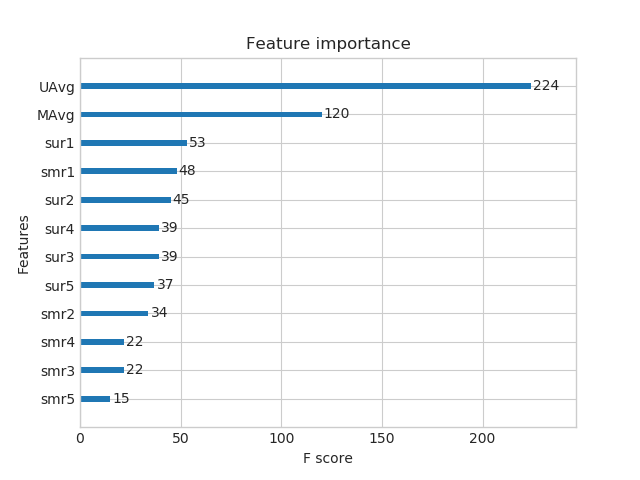

In [34]:
xgb.plot_importance(first_xgb)
plt.show()

### For Test Data :

In [35]:
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

In [36]:
first_xgb_test_pred = first_xgb.predict(x_test)
first_xgb_rmse_test, first_xgb_mape_test = get_error_metrics(y_true=y_test.values, y_pred=first_xgb_test_pred)

#####################################################
## Storing these error metrics to our global dictionary.. 
models_evaluation_test['first_xgb'] = {'rmse': first_xgb_rmse_test, 'mape':first_xgb_mape_test}
models_evaluation_test['first_xgb']['predictions'] = first_xgb_test_pred
#####################################################

In [37]:
models_evaluation_test['first_xgb']

{'mape': 35.03456000202348,
 'predictions': array([3.854013 , 2.3819778, 3.0049725, ..., 3.4059603, 3.237263 ,
        3.0150583], dtype=float32),
 'rmse': 1.190164934503154}

- ### Method to run any ___SURPRISE___ based algorithm 

In [38]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

import random
import numpy as np

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

In [39]:
##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

## 1.2. Surprise -  CustomBaseLineModel 
    - with normal baseline model, we can't  count the number of cold start problems
    - we will do this only for one model. Number of cold start cases will not change anyway.
    - Because, we are training and testing from the same dataset for all the models.

- #### Predicted_rating : ( baseline prediction )

http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly

 >$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $

-
- $\pmb \mu $ : Average of all trainings in TRAINSET
- $\pmb b_u$ : User bias
- $\pmb b_i$ : Item bias (movie biases)

- ####  Optimization function ( Least Squares Problem )

http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration

> $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).\text {        [mimimize } {b_u, b_i]}$

In [43]:
from surprise import BaselineOnly

In [44]:
# baseline model that let's us to see how many cold start cases are handled.. (not needed)
class BaseLineAlgo(BaselineOnly):

    def __init__(self, sim_options={}, bsl_options={}):

        BaselineOnly.__init__(self, bsl_options=bsl_options)

    def fit(self, trainset):
        self.trainset = trainset
        BaselineOnly.fit(self, trainset)
        return self

    def estimate(self, u, i):
        details = {'cold_start':False}
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            details = {'cold_start':True}
        
        return BaselineOnly.estimate(self, u, i), details
#########################################################################
# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
my_bsl_algo = BaseLineAlgo(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(my_bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
#########################################################################
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results
#########################################################################

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:01.001404 

Evaluating the model with train data..
time taken : 0:00:01.241123
---------------
Train Data
---------------
RMSE : 0.9312622541249634

MAPE : 28.756547341945467

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.067781
---------------
Test Data
---------------
RMSE : 1.1674790109548865

MAPE : 35.805018461619866

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:02.310976


## 1.3  XGBoost with Baseline Predictor

### 1.3.1 train XGBoost with this additional baseline feature

In [45]:
# previously....
reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1590,0,3.624457,1.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,2.0,3.0,3.895522,2.0,3.0
1,1907,0,3.624457,3.0,2.0,2.0,2.0,2.0,1.0,4.0,4.0,5.0,4.0,3.238636,2.0,1.0


In [46]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,1590,0,3.624457,1.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,2.0,3.0,3.895522,2.0,3.0,3.80965
1,1907,0,3.624457,3.0,2.0,2.0,2.0,2.0,1.0,4.0,4.0,5.0,4.0,3.238636,2.0,1.0,3.19968


In [47]:
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

xgb_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
xgb_bsl.fit(x_train, y_train,eval_metric='rmse')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=10, nthread=None, objective='reg:linear', random_state=15,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

<IPython.core.display.Javascript object>


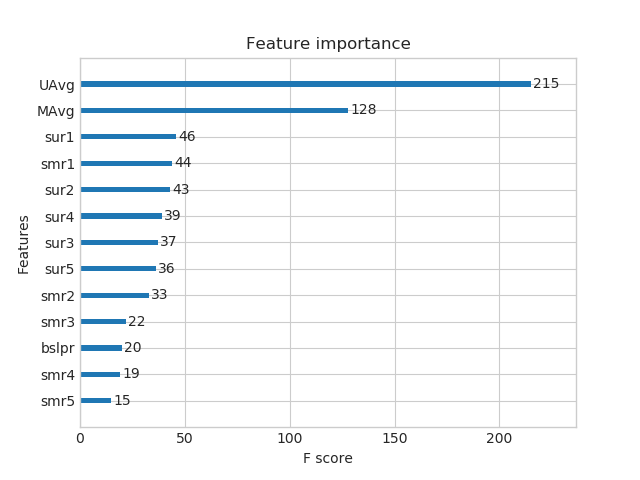

In [48]:
xgb.plot_importance(xgb_bsl)
plt.show()

In [49]:
# from the trained model, get the predictions....
start =datetime.now()
xgb_bsl_train_pred = xgb_bsl.predict(x_train)
print('Time taken to get the predictions :',datetime.now()-start)

# get the rmse and mape of train data...
xgb_bsl_rmse_train, xgb_bsl_mape_train = get_error_metrics(y_train.values, xgb_bsl_train_pred)


###################################################
## Store the errors values in our global dictionary...
models_evaluation_train['xgb_bsl'] = {'rmse':xgb_bsl_rmse_train, 'mape':xgb_bsl_mape_train}
models_evaluation_train['xgb_bsl']['predictions'] = xgb_bsl_train_pred
###################################################

Time taken to get the predictions : 0:00:00.185944


In [50]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,118,0,3.624457,5.0,4.0,4.0,5.0,4.0,4.20339,4.20339,4.20339,4.20339,4.20339,4.20339,2.0,3.0,3.948776
1,192,0,3.624457,3.0,3.0,2.0,4.0,4.0,5.00000,4.00000,3.00000,3.00000,3.00000,3.00000,2.0,5.0,3.542484


In [51]:
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']


xgb_bsl_test_preds = xgb_bsl.predict(x_test)
xgb_bsl_rmse_test, xgb_bsl_mape_test = get_error_metrics(y_true=y_test.values, y_pred=xgb_bsl_test_preds)

#####################################################
## Storing these error metrics to our global dictionary.. 
models_evaluation_test['xgb_bsl'] = {'rmse': xgb_bsl_rmse_test, 'mape': xgb_bsl_mape_test}
models_evaluation_test['xgb_bsl']['predictions'] = xgb_bsl_test_preds
#####################################################

In [52]:
models_evaluation_test['xgb_bsl']

{'mape': 35.05026182158571,
 'predictions': array([3.8989341, 2.40227  , 3.0303586, ..., 3.402841 , 3.2198586,
        3.0186212], dtype=float32),
 'rmse': 1.1896540970709255}

> Seems, there is a __small improvement__ with adding just  ___baseline predictions___ to the model.. 

# 2. KNN with BaseLineModel

In [54]:
from surprise import KNNBaseline

- KNN BASELINE
    - http://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline

- PEARSON_BASELINE SIMILARITY
    - http://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson_baseline

- SHRINKAGE
    - _2.2 Neighborhood Models_ in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf

- __predicted Rating__ : ( ___ based on User-User similarity ___ )

\begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} \end{align}

- $\pmb{b_{ui}}$ -  _Baseline prediction_ of (user,movie) rating

- $ \pmb {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  

- _sim (u, v)_ - __Similarity__ between users __u and v__  
    - Generally, it will be cosine similarity or Pearson correlation coefficient. 
    - But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take base line predictions instead of mean rating of user/item)
        - Computation of the correlation coefficient is based only on the common user support.
        - similarities based on a greater user support are more reliable ie., Users who has more number of common movie ratings are considered as more similar than users who has few no of movies  in common which are rated.
        - \begin{align}\begin{aligned}\text{pearson_baseline_shrunk_sim}(u, v) &= \frac{|I_{uv}| - 1}{|I_{uv}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{uv}\end{aligned}\end{align}
            - $\pmb{|I_{uv}|}$ - No of common movies between users(u and v)
            - __shrinkage__ - kind of hyperparameter. The defalut value suggested is ___100___
                - __0__ : There is no shrinkage at all ( It is normal pearson correlation coefficient ) 
                      
           - $ \pmb {\hat \rho_uv}$ - Pearson Correlation Coefficient ( between users )
                - \begin{align} \text{pearson_baseline_sim}(u, v) = \hat{\rho}_{uv} = \frac{
    \sum\limits_{i \in I_{uv}} (r_{ui} -  b_{ui}) \cdot (r_{vi} -
    b_{vi})} {\sqrt{\sum\limits_{i \in I_{uv}} (r_{ui} -  b_{ui})^2}
    \cdot \sqrt{\sum\limits_{i \in I_{uv}} (r_{vi} -  b_{vi})^2}} \end{align}


 ------------ or 
 --

- __ Predicted rating __ ( based on Item Item similarity ):
 \begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)} \end{align}

    -  ___Notations follows same as above (user user based predicted rating ) ___

- We can do both and blend them ( see if we can better results when combined ) 

## 2.1 KNN with User User similarities 

In [57]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
#########################################################################
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results
#########################################################################

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:35.219067 

Evaluating the model with train data..
time taken : 0:01:42.597450
---------------
Train Data
---------------
RMSE : 0.3417970858238777

MAPE : 9.193187599095861

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.934980
---------------
Test Data
---------------
RMSE : 1.3237746757149595

MAPE : 38.31024860443015

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:18.752029


## 2.2 KNN with Item Item similarities 

In [59]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
#########################################################################
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results
#########################################################################

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:01.384756 

Evaluating the model with train data..
time taken : 0:00:09.395003
---------------
Train Data
---------------
RMSE : 0.3417565257994054

MAPE : 8.832096148214427

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.382590
---------------
Test Data
---------------
RMSE : 1.330457797347872

MAPE : 38.381203718832154

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:11.163191


## 2.3 XGBoost with both KNNs(U_U and M_M sims) 

- - - First we will run XGBoost with predictions from both KNN's ( that uses User\_User and Item\_Item similarities along with our previous features.

 
- - - Then we will run XGBoost with just predictions form both knn models and preditions from our baseline model.

- ### Preparing Train data

In [64]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,1590,0,3.624457,1.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,2.0,3.0,3.895522,2.0,3.0,3.80965,3.000000,3.055318
1,1907,0,3.624457,3.0,2.0,2.0,2.0,2.0,1.0,4.0,4.0,5.0,4.0,3.238636,2.0,1.0,3.19968,4.049548,4.193583


- ###  Preparing Test data 

In [65]:
reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,118,0,3.624457,5.0,4.0,4.0,5.0,4.0,4.20339,4.20339,4.20339,4.20339,4.20339,4.20339,2.0,3.0,3.948776
1,192,0,3.624457,3.0,3.0,2.0,4.0,4.0,5.00000,4.00000,3.00000,3.00000,3.00000,3.00000,2.0,5.0,3.542484


In [66]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,118,0,3.624457,5.0,4.0,4.0,5.0,4.0,4.20339,4.20339,4.20339,4.20339,4.20339,4.20339,2.0,3.0,3.948776,1.861352,3.712417
1,192,0,3.624457,3.0,3.0,2.0,4.0,4.0,5.00000,4.00000,3.00000,3.00000,3.00000,3.00000,2.0,5.0,3.542484,3.239671,3.239671


### 2.3.1 Running the XGBoost

In [69]:
print('Preparing train data..')
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']
print('Done.')

print('Training the model with the new train data....')
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)

xgb_knn_bsl.fit(x_train, y_train,eval_metric='rmse')

Preparing train data..
Done.
Training the model with the new train data....


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=10, nthread=None, objective='reg:linear', random_state=15,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

<IPython.core.display.Javascript object>


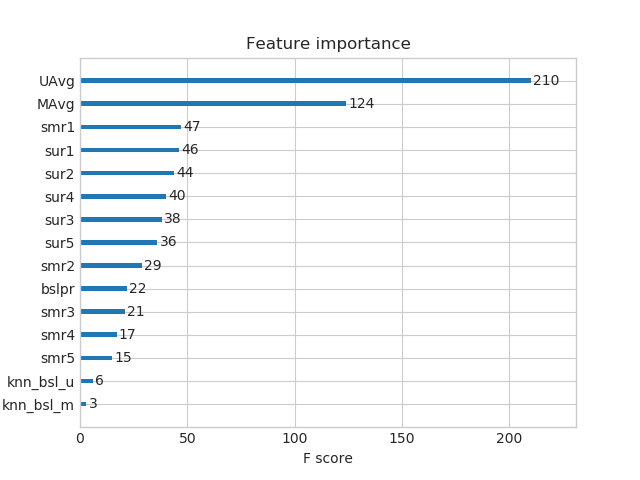

In [70]:
xgb.plot_importance(xgb_knn_bsl)
plt.show()

 #### 2.3.1.1 Evaluating with Train Data

In [72]:
# from the trained model, get the predictions....
start =datetime.now()
xgb_knn_bsl_train_preds = xgb_knn_bsl.predict(x_train)
print('Time taken to get the predictions :',datetime.now()-start)

# get the rmse and mape of train data...
xgb_knn_bsl_rmse_train, xgb_knn_bsl_mape_train = get_error_metrics(y_train.values, xgb_knn_bsl_train_preds)


###################################################
## Store the errors values in our global dictionary...
models_evaluation_train['xgb_knn_bsl'] = {'rmse':xgb_knn_bsl_rmse_train,
                                          'mape':xgb_knn_bsl_mape_train}
models_evaluation_train['xgb_knn_bsl']['predictions'] = xgb_knn_bsl_train_preds
###################################################

Time taken to get the predictions : 0:00:05.140471


In [74]:
models_evaluation_train['xgb_knn_bsl']

{'mape': 25.046362228242753,
 'predictions': array([2.3893242, 1.7582989, 3.4051952, ..., 3.0375829, 3.0123816,
        3.8105946], dtype=float32),
 'rmse': 0.8473864436138375}

 #### 2.3.3.2 Evaluating with Test Data

In [76]:
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']


xgb_knn_bsl_test_preds = xgb_knn_bsl.predict(x_test)
xgb_knn_bsl_rmse_test, xgb_knn_bsl_mape_test = get_error_metrics(y_true=y_test.values,y_pred=xgb_knn_bsl_test_preds)

#####################################################
## Storing these error metrics to our global dictionary.. 
models_evaluation_test['xgb_knn_bsl'] = {'rmse': xgb_knn_bsl_rmse_test, 'mape': xgb_knn_bsl_mape_test}
models_evaluation_test['xgb_knn_bsl']['predictions'] = xgb_knn_bsl_test_preds
#####################################################

In [77]:
models_evaluation_test['xgb_knn_bsl']

{'mape': 35.038058509526124,
 'predictions': array([3.7395442, 2.2806654, 2.9937184, ..., 3.3904822, 3.2134793,
        3.0181227], dtype=float32),
 'rmse': 1.1908716570574163}

### 2.3.3b Running the XGBoost ( with just two (UU and MM) nearest Neighbour predictors

In [79]:
# preparing train data
x_train = reg_train[['knn_bsl_u','knn_bsl_m']]
y_train = reg_train['rating']

# preparing test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m']]
y_test = reg_test_df['rating']

<IPython.core.display.Javascript object>


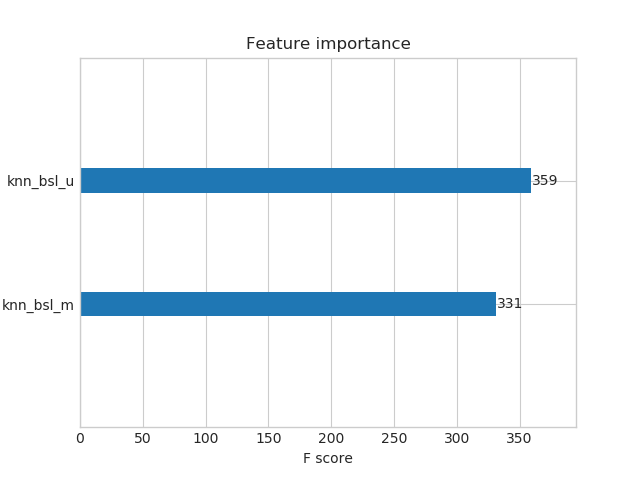

In [80]:
xgb_knn_bsl_mu = xgb.XGBRegressor(n_jobs=10, random_state=15)

xgb_knn_bsl_mu.fit(x_train, y_train)

xgb.plot_importance(xgb_knn_bsl_mu)
plt.show()

- __Evaluating the model with the train data__

In [81]:
xgb_knn_bsl_mu_train_preds = xgb_knn_bsl_mu.predict(x_train)
# get the errors (rmse and mape)
xgb_knn_bsl_mu_train_rmse, xgb_knn_bsl_mu_train_mape = get_error_metrics(y_true=y_train.values, 
                                                                        y_pred = xgb_knn_bsl_mu_train_preds)

######################################################
# store them in models dictionary..
models_evaluation_train['xgb_knn_bsl_mu'] = {'rmse' : xgb_knn_bsl_mu_train_rmse,
                                             'mape' : xgb_knn_bsl_mu_train_mape}
models_evaluation_train['xgb_knn_bsl_mu']['predictions'] = xgb_knn_bsl_mu_train_preds
######################################################

In [84]:
models_evaluation_train['xgb_knn_bsl_mu']

{'mape': 35.12240768004972,
 'predictions': array([3.6162918, 3.6283565, 3.6287675, ..., 3.6165812, 3.6165812,
        3.6287675], dtype=float32),
 'rmse': 1.0765761031719971}

- __Evaluating the model with test data__ 

In [85]:
# get the predictions for the test data
xgb_knn_bsl_mu_test_preds = xgb_knn_bsl_mu.predict(x_test)
# get error metrics and store them in models dictionary
xgb_knn_bsl_mu_test_rmse, xgb_knn_bsl_mu_test_mape = get_error_metrics(y_test.values, xgb_knn_bsl_mu_test_preds)

# store them in models dictionary
######################################################
models_evaluation_test['xgb_knn_bsl_mu'] = {'rmse': xgb_knn_bsl_mu_test_rmse, 
                                            'mape': xgb_knn_bsl_mu_test_mape}
models_evaluation_test['xgb_knn_bsl_mu']['predictions'] = xgb_knn_bsl_mu_test_preds
######################################################

In [86]:
models_evaluation_test['xgb_knn_bsl_mu']

{'mape': 35.0674775318328,
 'predictions': array([3.4530203, 3.6423204, 3.6423204, ..., 3.6423204, 3.6423204,
        3.6423204], dtype=float32),
 'rmse': 1.1055235712162623}

# 3. Matrix Factorization Techniques

### 3.1 SVD -  MF algorithm with user item interactions

http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD 

- __ Predicted Rating : __
    - 
    - $ \large  \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $
    
        - $\pmb q_i$ - Representation of item(movie) in latent factor space
        
        - $\pmb p_u$ - Representation of user in new latent factor space
        


- A BASIC MATRIX FACTORIZATION MODEL in  https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf

- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $

In [87]:
from surprise import SVD

In [89]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
#########################################################################
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results
#########################################################################

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:07.939111 

Evaluating the model with train data..
time taken : 0:00:01.567476
---------------
Train Data
---------------
RMSE : 0.6523640307015464

MAPE : 19.35960301225469

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.104272
---------------
Test Data
---------------
RMSE : 1.2363770938140637

MAPE : 36.778362706113526

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:09.611640


### 3.2 SVD -  with Implicit feedback from user ( user rated movies )

- ----->  2.5 Implicit Feedback in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf

- __ Predicted Rating : __
    - 
    - $ \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
    |I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right) $

- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $ \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + y_j^2\right) $

In [91]:
from surprise import SVDpp

In [96]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
#########################################################################
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results
#########################################################################

Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:02:13.523230 

Evaluating the model with train data..
time taken : 0:00:09.066185
---------------
Train Data
---------------
RMSE : 0.6079436835198637

MAPE : 17.591518882877512

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.359959
---------------
Test Data
---------------
RMSE : 1.2475081306270126

MAPE : 36.6724863476801

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:22.950386


In [95]:
models_evaluation_test['svdpp']

{'mape': 36.6724863476801,
 'predictions': array([3.8624555 , 3.21491122, 3.20947053, ..., 3.18721167, 3.31064836,
        3.27990616]),
 'rmse': 1.2475081306270126}

## 4.  XGBoost with predictions from previous models 

### Preparing Train data

In [97]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,1590,0,3.624457,1.0,2.0,2.0,2.0,2.0,3.0,4.0,...,2.0,3.0,3.895522,2.0,3.0,3.80965,3.000000,3.055318,3.529684,3.351226
1,1907,0,3.624457,3.0,2.0,2.0,2.0,2.0,1.0,4.0,...,5.0,4.0,3.238636,2.0,1.0,3.19968,4.049548,4.193583,3.853352,4.265729


###  Preparing Test data 

In [98]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,118,0,3.624457,5.0,4.0,4.0,5.0,4.0,4.20339,4.20339,...,4.20339,4.20339,4.20339,2.0,3.0,3.948776,1.861352,3.712417,3.862455,3.862455
1,192,0,3.624457,3.0,3.0,2.0,4.0,4.0,5.00000,4.00000,...,3.00000,3.00000,3.00000,2.0,5.0,3.542484,3.239671,3.239671,3.214911,3.214911


In [101]:
reg_train.columns

Index(['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5', 'smr1',
       'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating', 'bslpr',
       'knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp'],
      dtype='object')

### 4.1 Running the XGBoost (with just predictions from previous models)

0:00:02.316059


<IPython.core.display.Javascript object>


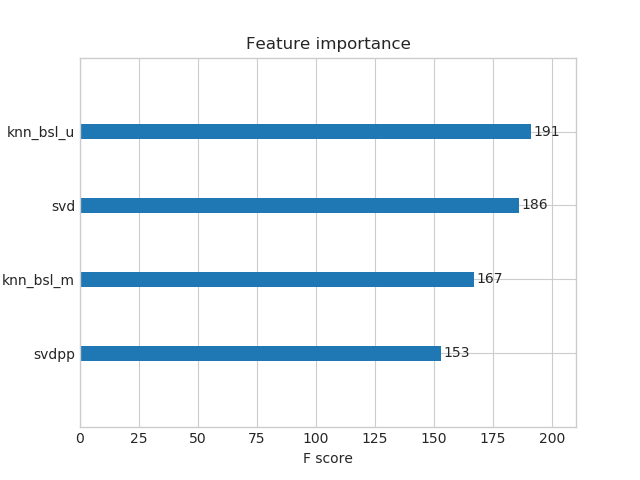

In [111]:
xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)

x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

start = datetime.now()
xgb_all_models.fit(x_train, y_train)
print(datetime.now()- start)

xgb.plot_importance(xgb_all_models)
plt.show()

 #### 4.1.1 Evaluating with Train Data

In [112]:
# get the training predictions.............
xgb_all_models_train_preds = xgb_all_models.predict(x_train)
# find the error metrics and store them in dictionary..
xgb_all_models_train_rmse, xgb_all_models_train_mape = get_error_metrics(y_true = y_train.values,
                                                                         y_pred = xgb_all_models_train_preds)

# adding it's metrics to models dictionary 
#####################################################################
models_evaluation_train['xgb_all_models'] = {'rmse' : xgb_all_models_train_rmse,
                                          'mape' : xgb_all_models_train_mape}
models_evaluation_train['xgb_all_models']['predictions'] = xgb_all_models_train_preds

In [113]:
models_evaluation_train['xgb_all_models']

{'mape': 35.10431211320362,
 'predictions': array([3.6135259, 3.640571 , 3.6309824, ..., 3.6073282, 3.575307 ,
        3.628288 ], dtype=float32),
 'rmse': 1.0760427305617022}

 #### 4.1.2 Evaluating with Test Data

In [114]:
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']

# get the predicted ratings for this test data
start = datetime.now()
xgb_all_models_test_predictions = xgb_all_models.predict(x_test)
print(datetime.now() - start)

xgb_all_models_test_rmse, xgb_all_models_test_mape = get_error_metrics(y_test.values,
                                                                        xgb_all_models_test_predictions) 

################################################################
models_evaluation_test['xgb_all_models'] = {'rmse' : xgb_all_models_test_rmse,'mape' : xgb_all_models_test_mape}
models_evaluation_test['xgb_all_models']['predictions'] = xgb_all_models_test_predictions

0:00:00.013754


In [116]:
models_evaluation_test['xgb_all_models']

{'mape': 35.04546712205308,
 'predictions': array([3.6877782, 3.6431882, 3.6431882, ..., 3.6431882, 3.6431882,
        3.6431882], dtype=float32),
 'rmse': 1.1031774265441174}

### 4.2 Running the XGBoost ( with everything )

0:00:03.856444


<IPython.core.display.Javascript object>


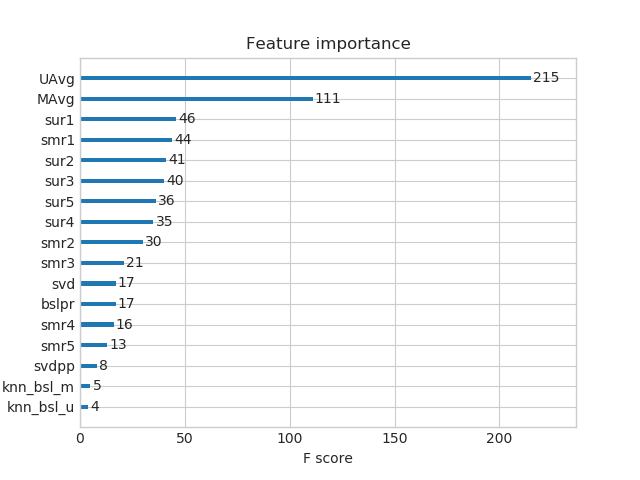

In [117]:
xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)

# preparing x_train and y_train accordingly..
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# train the xgboost model
start = datetime.now()
xgb_final.fit(x_train, y_train)
print(datetime.now()- start)

xgb.plot_importance(xgb_final)
plt.show()

 #### 4.2.1 Evaluating with Train Data

In [118]:
# get predicted ratings for train data..
xgb_final_train_preds = xgb_final.predict(x_train)

# find the error metrics and store them in dictionary..
xgb_final_train_rmse, xgb_final_train_mape = get_error_metrics(y_true = y_train.values,
                                                               y_pred = xgb_final_train_preds)

# adding it's metrics to models dictionary 
#####################################################################
models_evaluation_train['xgb_final'] = {'rmse' : xgb_final_train_rmse,
                                        'mape' : xgb_final_train_mape}
models_evaluation_train['xgb_final']['predictions'] = xgb_final_train_preds

In [120]:
models_evaluation_train['xgb_final']

{'mape': 25.04382635477409,
 'predictions': array([2.3636472, 1.7309597, 3.41015  , ..., 3.0416324, 3.0438082,
        3.8217218], dtype=float32),
 'rmse': 0.8471740634332018}

 #### 4.2.2 Evaluating with Test Data

In [121]:
# prepare the test and 
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']

# get the predicted ratings for this test data
xgb_final_test_predictions = xgb_final.predict(x_test)

# get rmse and mape of this model
xgb_final_test_rmse, xgb_final_test_mape = get_error_metrics(y_test.values, xgb_final_test_predictions)

# store them
################################
models_evaluation_test['xgb_final'] = {'rmse' : xgb_final_test_rmse,
                                         'mape' : xgb_final_test_mape}
models_evaluation_test['xgb_final']['predictions'] = xgb_final_test_predictions

In [123]:
models_evaluation_test['xgb_final']

{'mape': 35.083767122978166,
 'predictions': array([3.8863575, 2.37492  , 3.0160525, ..., 3.4118242, 3.233978 ,
        3.0079606], dtype=float32),
 'rmse': 1.1891823494343936}

- __Saving the result dataframe so that you don't have to run it again..__ 

In [142]:
pd.DataFrame(models_evaluation_test).to_csv('sample/small_sample_results.csv')

- - - - - - - - - - - -  - - - - - - - - - - - - - - - - - - - - - - , 
- - - - - - - - - - - -  - - - - - - - - - - - - - - - - - - - - - - , 
- - - - - - - - - - - -  - - - - - - - - - - - - - - - - - - - - - - , 


- __ Reading from the dataframe that was saved in the disk__

In [150]:
models_ = pd.read_csv('sample/small_sample_results.csv', index_col=0)
models_

,bsl_algo,first_xgb,knn_bsl_m,knn_bsl_u,svd,svdpp,xgb_all_models,xgb_bsl,xgb_final,xgb_knn_bsl,xgb_knn_bsl_mu
mape,35.805018461619866,35.03456000202348,38.381203718832154,38.31024860443015,36.6724863476801,36.6724863476801,35.04546712205308,35.05026182158571,35.083767122978166,35.038058509526124,35.0674775318328
predictions,[3.9487763 3.54248358 3.56137288 ... 3.518495...,[3.854013 2.3819778 3.0049725 ... 3.4059603 3...,[3.71241676 3.23967081 3.34715901 ... 3.318686...,[1.8613519 3.23967081 3.34715901 ... 3.318686...,[3.8624555 3.21491122 3.20947053 ... 3.187211...,[3.8624555 3.21491122 3.20947053 ... 3.187211...,[3.6877782 3.6431882 3.6431882 ... 3.6431882 3...,[3.8989341 2.40227 3.0303586 ... 3.402841 3...,[3.8863575 2.37492 3.0160525 ... 3.4118242 3...,[3.7395442 2.2806654 2.9937184 ... 3.3904822 3...,[3.4530203 3.6423204 3.6423204 ... 3.6423204 3...
rmse,1.1674790109548865,1.190164934503154,1.330457797347872,1.3237746757149595,1.2475081306270126,1.2475081306270126,1.1031774265441174,1.1896540970709255,1.1891823494343936,1.1908716570574163,1.1055235712162623


In [151]:
models_.loc['rmse'].sort_values()

xgb_all_models    1.1031774265441174
xgb_knn_bsl_mu    1.1055235712162623
bsl_algo          1.1674790109548865
xgb_final         1.1891823494343936
xgb_bsl           1.1896540970709255
first_xgb          1.190164934503154
xgb_knn_bsl       1.1908716570574163
svd               1.2475081306270126
svdpp             1.2475081306270126
knn_bsl_u         1.3237746757149595
knn_bsl_m          1.330457797347872
Name: rmse, dtype: object

In [152]:
models_.loc['mape'].sort_values()

first_xgb          35.03456000202348
xgb_knn_bsl       35.038058509526124
xgb_all_models     35.04546712205308
xgb_bsl            35.05026182158571
xgb_knn_bsl_mu      35.0674775318328
xgb_final         35.083767122978166
bsl_algo          35.805018461619866
svd                 36.6724863476801
svdpp               36.6724863476801
knn_bsl_u          38.31024860443015
knn_bsl_m         38.381203718832154
Name: mape, dtype: object